In [37]:
%reload_ext autoreload
%autoreload 2
# Boilerplate imports.
import numpy as np
import pickle
from saliency.core.base import *
from saliency.core import IntegratedGradients
import torch
import torch.nn.functional as F
import ig2
from ig2 import REP_LAYER_VALUES, REP_DISTANCE_GRADIENTS
from models.model import wafer_CNN
import torch.nn as nn
import os

### Load TREC dataset and fault patter classification model

Small subset of wafermap training dataset is used for testing the attribution method.

In [38]:
model = wafer_CNN(3, 9, 8 * 8 * 128).cuda()
model.load_state_dict(torch.load('models/wafer_cnn_dict.pt'))
model.eval()
rep_layer = model.layer4
rep_layer_outputs = {}
def rep_layer_forward(m, i, o):
    rep_layer_outputs[REP_LAYER_VALUES] = o
forward_hook = rep_layer.register_forward_hook(rep_layer_forward)

resized_wm = np.load('data/wafer/data_subset.npy')
label_wm = np.load('data/wafer/label_subset.npy')
faulty_case = np.unique(label_wm)
for i, l in enumerate(faulty_case):
    label_wm[label_wm==l] = i    
    # print('i : {}, label : {}'.format(i, l))
data = np.moveaxis(resized_wm,1,3)
targets = np.int64(label_wm).ravel()

### Utility methods

In [39]:
class_idx_str = 'class_idx_str'

def PreprocessImages(images):
    images = np.transpose(images, (0,3,1,2))
    images = torch.tensor(images, dtype=torch.float32).cuda()
    return images.requires_grad_(True)


def call_model_function(images, call_model_args=None, expected_keys=None):
    images = PreprocessImages(images)
    target_class_idx =  torch.LongTensor(np.array(call_model_args[class_idx_str]).reshape(-1,1)).cuda()
    logits = model(images)
    # m = torch.nn.Softmax(dim=1)
    # output = m(logits)
    if INPUT_OUTPUT_GRADIENTS in expected_keys:
        # outputs = logits[:,target_class_idx]
        if logits.size(0)>1 and target_class_idx.size(0) == 1:
            target_class_idx = target_class_idx.repeat(logits.size(0),1) 
        target_class_idx = torch.zeros_like(logits).scatter_(1, target_class_idx, 1).detach()        
        grads = torch.autograd.grad(logits, images, grad_outputs=target_class_idx)
        grads = torch.movedim(grads[0], 1, 3)
        gradients = grads.cpu().detach().numpy()
        return {INPUT_OUTPUT_GRADIENTS: gradients}

    if REP_LAYER_VALUES in expected_keys:        
        return rep_layer_outputs

    if REP_DISTANCE_GRADIENTS in expected_keys:
        loss_fn = torch.nn.MSELoss()
        
        baseline_conv = call_model_args['layer_baseline']
        input_conv = rep_layer_outputs[REP_LAYER_VALUES]
        loss = -1 * loss_fn(input_conv, baseline_conv)
        loss.backward()
        grads = images.grad.data
        grads = torch.movedim(grads, 1, 3)
        gradients = grads.cpu().detach().numpy()
        return {REP_DISTANCE_GRADIENTS: gradients,
                'loss':loss}

### Load explained sample and references
The references of explaining the fault samples are non-fault samples.

In [40]:
t = 0
x = data[targets==t,:]
y = targets[targets==t]
normal_distribution = data[targets==8,:] # Select the normal samples as the reference
black = np.zeros(normal_distribution[0].shape)

indx_target = [0,0,2,6,5,0,0,2] # Specified
np.random.seed(2)
explicand_list = []
explicand_class_list = []

for t in [0,1,2,3,4,5,6,7]:
    x = data[targets==t,:]
    y = targets[targets==t]
    for _ in range(1):
        # indx = indx_target[t]
        indx = np.random.choice(len(y)) #random sample
        explicand = x[indx,:]
        predictions = model(PreprocessImages([explicand]))
        predictions = predictions.cpu().detach().numpy()
        if predictions[0][t] <0.8:
            continue
        else:
            explicand_list.append(explicand)
            explicand_class_list.append(t)

explicand_list = np.array(explicand_list)
explicand_class_list = np.array(explicand_class_list)

### IG2 attribution

In [41]:
ig2_mask_list = []
GradCFE_list = []
for explicand, exp_class in zip(explicand_list, explicand_class_list):
    call_model_args = {class_idx_str: exp_class}
    explainer = ig2.IG2()
    ig2_mask, path = explainer.GetMask(explicand,normal_distribution[:10,:],
        call_model_function,call_model_args,steps=1001,step_size=0.05,clip_min_max=[0,1],return_path=True)
    ig2_mask_list.append(ig2_mask)
    GradCFE_list.append(np.mean(path[0]-path[-1],axis=0))

mask_dict = {
    'GradCFE':GradCFE_list,
    'IG2':ig2_mask_list,
}

GradPath search...
0 iterations, rep distance Loss -0.31022578477859497
100 iterations, rep distance Loss -0.07423139363527298
200 iterations, rep distance Loss -0.026178453117609024
300 iterations, rep distance Loss -0.016988201066851616
400 iterations, rep distance Loss -0.012697838246822357
500 iterations, rep distance Loss -0.009750515222549438
600 iterations, rep distance Loss -0.008246268145740032
700 iterations, rep distance Loss -0.007358493283390999
800 iterations, rep distance Loss -0.0067505007609725
900 iterations, rep distance Loss -0.006239526439458132
1000 iterations, rep distance Loss -0.005580202676355839
Integrate gradients on GradPath...
GradPath search...
0 iterations, rep distance Loss -7.908545017242432
100 iterations, rep distance Loss -4.398770332336426
200 iterations, rep distance Loss -2.277855634689331
300 iterations, rep distance Loss -1.0984041690826416
400 iterations, rep distance Loss -0.5566809177398682
500 iterations, rep distance Loss -0.35078471899032

### Visualize 

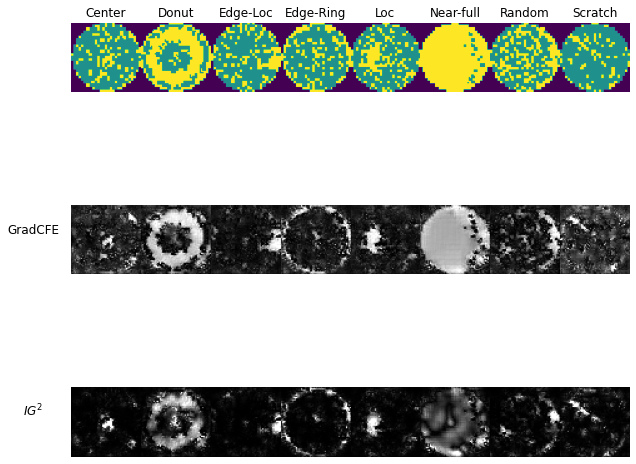

In [42]:
import matplotlib.pyplot as plt
import saliency.core.visualization as vis
def ShowGrayscaleImage(im, ax):
    if ax is None:
        plt.figure()
    ax.axis('off')
    ax.imshow(im, cmap=plt.cm.gray, vmin=0, vmax=1)

method_names = ['GradCFE','IG2']
labels2 = ['Center','Donut','Edge-Loc','Edge-Ring','Loc','Near-full','Random','Scratch','None']

fig = plt.figure(figsize=(10, 10), constrained_layout=False)
outer_grid = fig.add_gridspec(1, 8, wspace=0.005, hspace=0.)
np.random.seed(2)
for a in range(8):
    # gridspec inside gridspec
    inner_grid = outer_grid[0, a].subgridspec(3, 1, wspace=0, hspace=0.02)
    axes = inner_grid.subplots()  # Create all subplots for the inner grid.

    axes[0].imshow(np.argmax(explicand_list[a,:],axis=2))
    axes[0].set_title(f'{labels2[a]}')
    axes[0].axis('off')
    # title='Vanilla Gradient',
    for i in range(1,len(axes)):       
        mask_grayscale = vis.VisualizeImageGrayscale(mask_dict[method_names[i-1]][a])
        ShowGrayscaleImage(mask_grayscale, axes[i]) 

    if a == 0: #show title on the left
        for i, name in enumerate(method_names):
            if name == 'IG2':
                name = r'$IG^2$'
            axes[i+1].set_title(name, x=-0.55,y=0.5)

# show only the outside spines
for ax in fig.get_axes():
    ax.set_xticks([])
    ax.set_yticks([])
    ss = ax.get_subplotspec()
    ax.spines.top.set_visible(ss.is_first_row())
    ax.spines.bottom.set_visible(ss.is_last_row())
    ax.spines.left.set_visible(ss.is_first_col())
    ax.spines.right.set_visible(ss.is_last_col())
plt.show()
